# Data Quality Assessment 

First stage was to assess the data quality, in order to ascern whether exploring data quality within the skin lesion dataset would be a variable investigation. To do this we used the PyTorch Image Quality (PIQ) package, further information available at: https://github.com/photosynthesis-team/piq 
 and package documentation at: https://piq.readthedocs.io/en/latest/functions.html

We have initally chosen, Blind/Referenceless Image Spatial Quality Evaluator (BRISQUE) and Total Variation, as both of these are No Reference Metrics. 
 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install piq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 5.2 MB/s 


In [3]:
import torch
from piq import brisque, total_variation
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision.transforms as transforms
from os import listdir, path
from tqdm import tqdm
from statistics import mean
import numpy as np
import json
from skimage import io
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
import cv2
from multiprocessing import Pool, Manager
import os

Deciding on a range of images, inluding different sizes, and with black corner features to then test the skin colour analysis method...looking at options incuding rather than resizing and cropping all 25,000 images- to instead deal with the images in their original form and detct skin colour - mean less computationally expensive and will save time, and will mean the programme will work with any image input

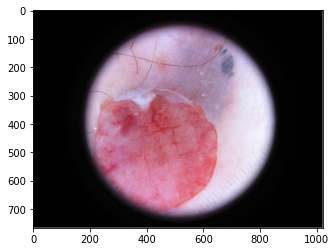

In [ ]:
test_image = io.imread("/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0000004.jpg")
plt.imshow(test_image)

In [ ]:


ax = plt.hist(test_image.ravel(), bins = 256)
plt.show()

(767, 1022, 3)

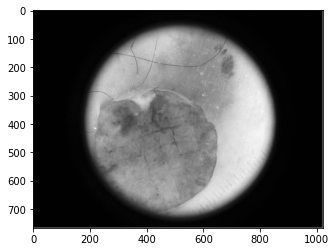

In [ ]:


img = io.imread("/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0000004.jpg")
imgGray = color.rgb2gray(img)

plt.imshow(imgGray, cmap= "gray")


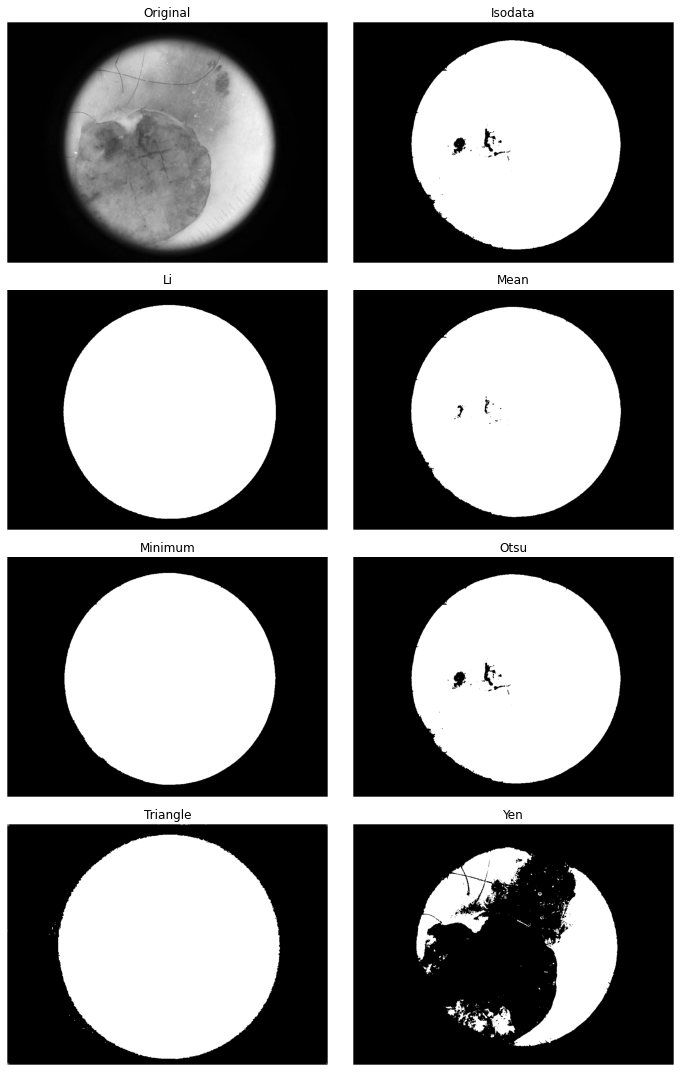

In [ ]:
from skimage.filters import try_all_threshold
from skimage.filters import threshold_li

fig, ax = try_all_threshold(imgGray, figsize=(10, 15), verbose=False)
plt.show()

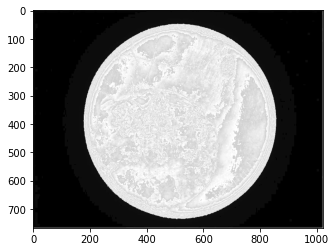

In [ ]:


li_image = threshold_li(imgGray)
masked = cv2.bitwise_and(imgGray, li_image)
#colour = color.gray2rgb(masked)
plt.imshow(masked, cmap = "gray")

In [ ]:
test_image.shape

(767, 1022, 3)

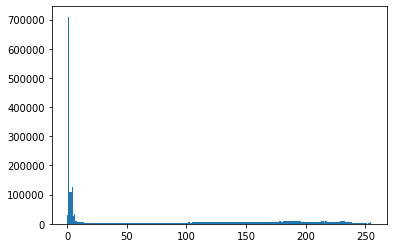

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])
  
# Convert the image to Torch tensor
# tensor = transform(test_image)

# # expand out dimenstions to 4, as axpected by image quality metrics 
# four_ten = tensor.reshape(1, *tensor.shape)

# brisque_index = brisque(four_ten)

# print(brisque_index)


In [8]:
#Creating function to iterate over individual images, claculate BRISQUE or TV score, then append each score to a list

def calculate_metric(metric, image_file_path, metric_scores):
    original_image = io.imread(image_file_path)

    #Convert the image to Torch tensor
    tensor = transform(original_image)
    # expand out dimenstions to 4, as axpected by image quality metrics 
    four_ten = tensor.reshape(1, *tensor.shape)

    #calculating metric
    metric_value = metric(four_ten)
    metric_scores[image_file_path] = metric_value.item()


def quality_assessment (metric, image_folder):
    images = []

    # getting the sorted list of file names and number of images
    file_names = sorted(listdir(image_folder))
    no_images = len(file_names)

    # initialising subplot index
    subplot_index = 1

    metric_scores = Manager().dict()

    params = []
  
    # iterating over images
    for i, image_file in enumerate(file_names, start=1):
        #loading original image
        image_file_path = path.join(image_folder, image_file)
        params.append((metric, image_file_path, metric_scores))

    with Pool(4) as p:
        print("Running pool")
        p.starmap(calculate_metric, tqdm(params, total=len(params)))

    return dict(metric_scores)

def v2_quality_assessment (metric, root_path):
    metric_scores = Manager().dict()
    params = []
  
    # iterating over images
    for root, dirs, files in os.walk(root_path, topdown=True):
        for name in files:
            image_file_path = os.path.join(root, name)
            params.append((metric, image_file_path, metric_scores))

    with Pool(4) as p:
        print("Running pool")
        p.starmap(calculate_metric, tqdm(params, total=len(params)))

    return dict(metric_scores)

## BRISQUE 

In [ ]:
image_folder = "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input"

brisque_metrics = quality_assessment(brisque, image_folder)

Running pool


100%|██████████| 25331/25331 [49:42<00:00,  8.49it/s]


In [ ]:

with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/brisque_metrics.json", "w") as f:
    json.dump(brisque_metrics, f, indent=4)


In [ ]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/brisque_metrics.json", "r") as f:
    brisque_metrics_reopened = json.load(f)

In [ ]:
brisque_metrics_reopened

{'/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0024571.jpg': 34.13885498046875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0026155.jpg': 30.97283935546875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0024572.jpg': 34.48065185546875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0026156.jpg': 32.62908935546875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0012905_downsampled.jpg': 49.08660888671875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0024573.jpg': 40.16912841796875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0026157.jpg': 31.70379638671875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0000000.jpg': 40.62078857421875,
 '/content/drive/MyDrive/Dissertation/skin_l

In [ ]:
brisque_values = brisque_metrics_reopened.values()
brisque_mean = mean(brisque_values)
print(brisque_mean)

37.140636510202576
25.707741485233676


(0.0, 1000.0)

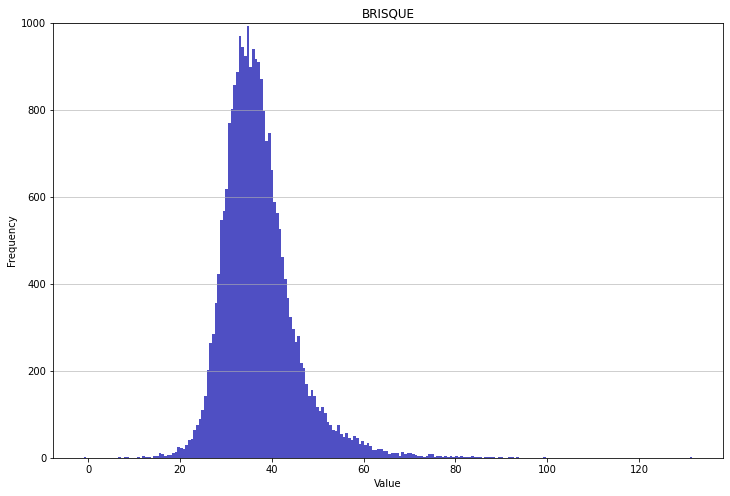

In [ ]:
# Histogram for BRISQUE 
plt.figure(figsize=(12, 8))
n, bins, patches = plt.hist(x=brisque_values, bins='auto', color='#0504aa',
                            alpha=0.7)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('BRISQUE')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

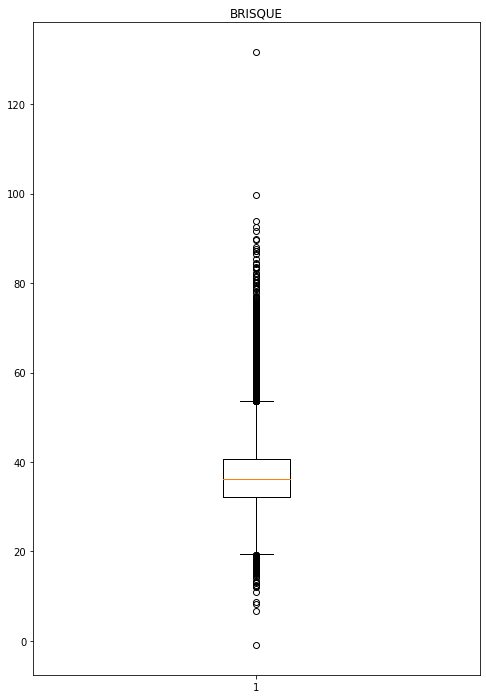

In [ ]:
# box plot for BRISQUE
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(1,1,1)
ax.boxplot(brisque_values)
ax.set_title('BRISQUE')
plt.show()

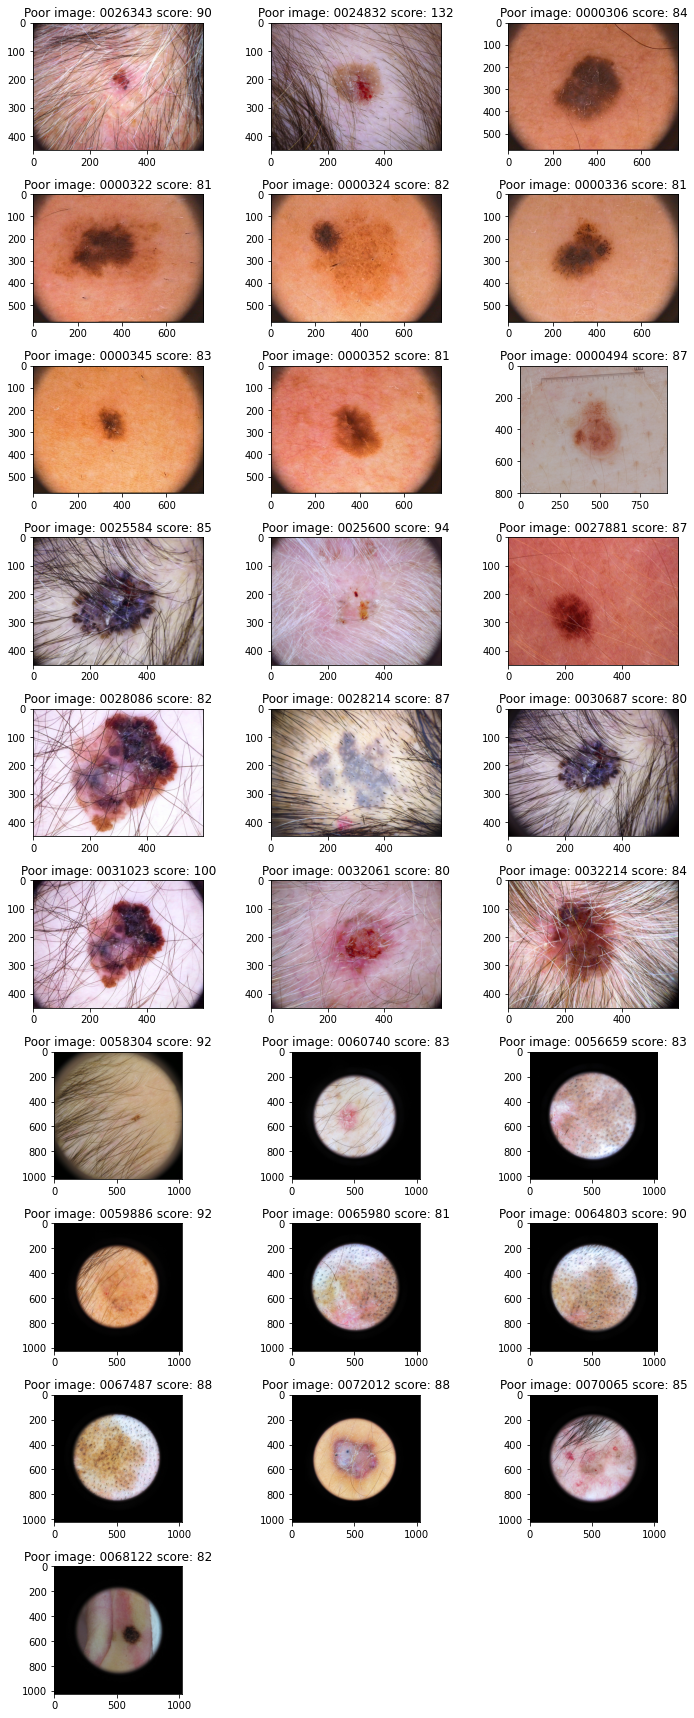

In [ ]:
# visulisation images with a high (and therefore poor) BRISQUE quality score of greater than 80 and lower than 20

# greater than 80
poor_brisq = {k: v for k, v in brisque_metrics_reopened.items() if v >= 80}
#len(poor_brisq)
#28

#initialising subplot index
subplot_index = 1
no_images = len(poor_brisq)
# creating the figure
fig = plt.figure(figsize=(10,200))

# iterating over images
for i, (image_file, score) in enumerate(poor_brisq.items(), start=1):
    original_image = io.imread(image_file)
    # Plot input image
    ax = fig.add_subplot(no_images*3, 3, subplot_index)
    ax.imshow(original_image)
    ax.set_title(f"Poor image: {image_file[-11:-4]} score: {round(score)}")
    subplot_index += 1

plt.tight_layout()
plt.show()

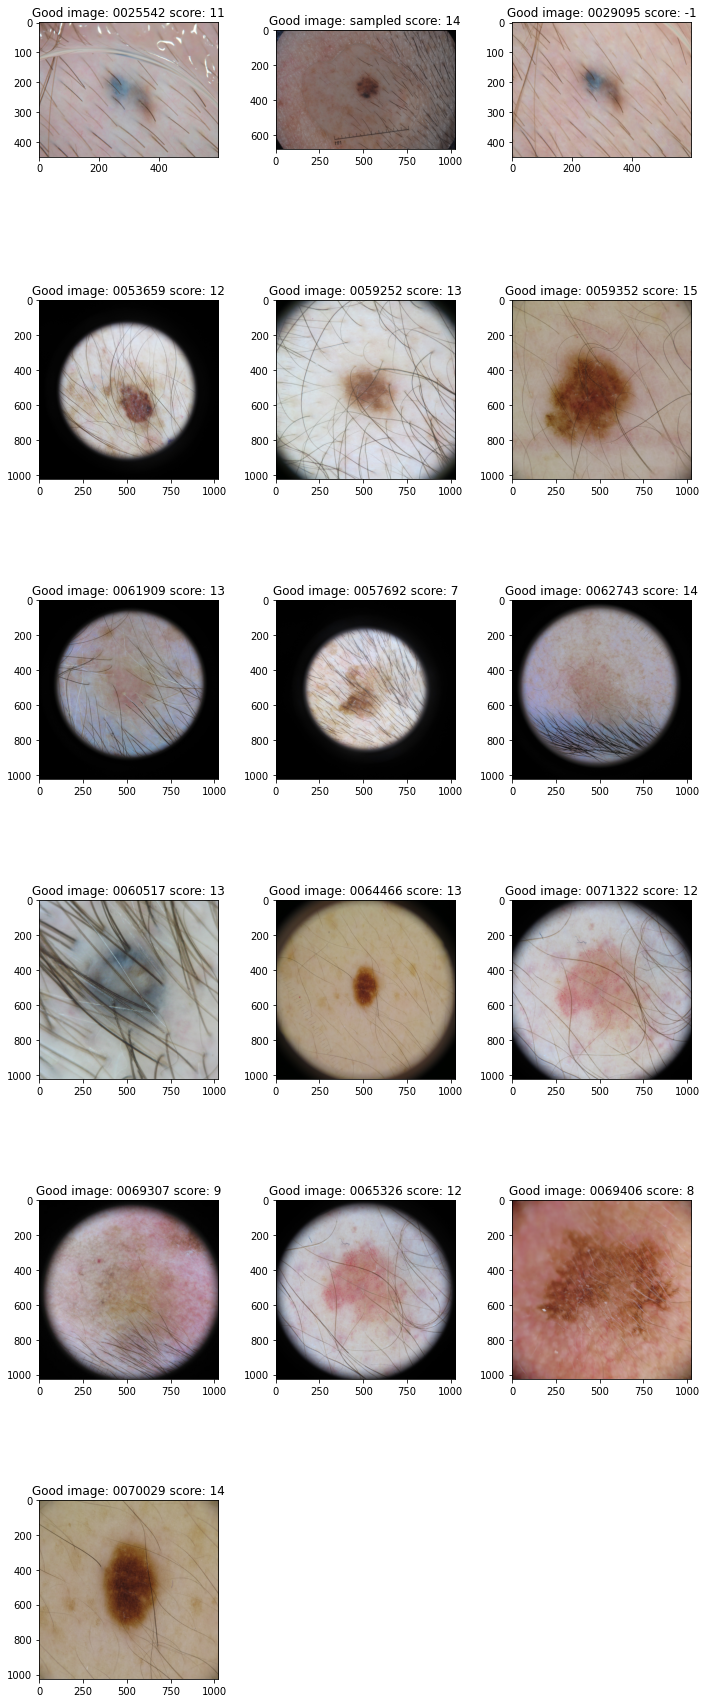

In [ ]:
## GOOD BRISQUE SCORE

# smaller than 20
good_brisq = {k: v for k, v in brisque_metrics_reopened.items() if v <= 15}

#initialising subplot index
subplot_index = 1
no_images = len(good_brisq)
# creating the figure
fig = plt.figure(figsize=(10,200))

# iterating over images
for i, (image_file, score) in enumerate(good_brisq.items(), start=1):
    original_image = io.imread(image_file)
    # Plot input image
    ax = fig.add_subplot(no_images*3, 3, subplot_index)
    ax.imshow(original_image)
    ax.set_title(f"Good image: {image_file[-11:-4]} score: {round(score)}")
    subplot_index += 1

plt.tight_layout()
plt.show()


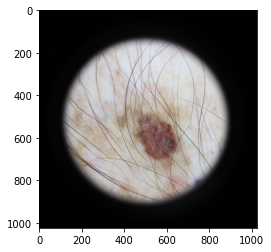

In [ ]:
good_images_names

test_good = io.imread('/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input/ISIC_0053659.jpg')
plt.imshow(test_good)

##BRISQUE for v2 TRAIN Preprocessed data (i.e. with hair removal and black circle crop applied)



In [4]:
root_path = "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/train"

v2_prepro_brisque_metrics = v2_quality_assessment(brisque, root_path)

NameError: ignored

In [ ]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/v2_prepro_brisque_metrics.json", "w") as f:
    json.dump(v2_prepro_brisque_metrics, f, indent=4)

In [ ]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/v2_prepro_brisque_metrics.json", "r") as f:
    v2_prepro_brisque_metrics_reopened = json.load(f)

In [ ]:
v2_prepro_brisque_metrics_reopened

{'/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/train/NV/ISIC_0033649.jpg': 20.37420654296875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/train/NV/ISIC_0026825.jpg': 11.08758544921875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/train/NV/ISIC_0067715.jpg': 25.52850341796875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/train/NV/ISIC_0013208_downsampled.jpg': 11.05438232421875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/train/NV/ISIC_0027535.jpg': 30.17645263671875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/train/NV/ISIC_0066130.jpg': 28.88739013671875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/train/NV/ISIC_0072650.jpg': 14.55682373046875,
 '/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/train/NV/ISIC_0056108.jpg': 10.68182373046875,
 '/content/d

In [ ]:
v2_brisque_values = v2_prepro_brisque_metrics_reopened.values()
v2_brisque_mean = mean(v2_brisque_values)
print(v2_brisque_mean)

22.564726710931332


(0.0, 850.0)

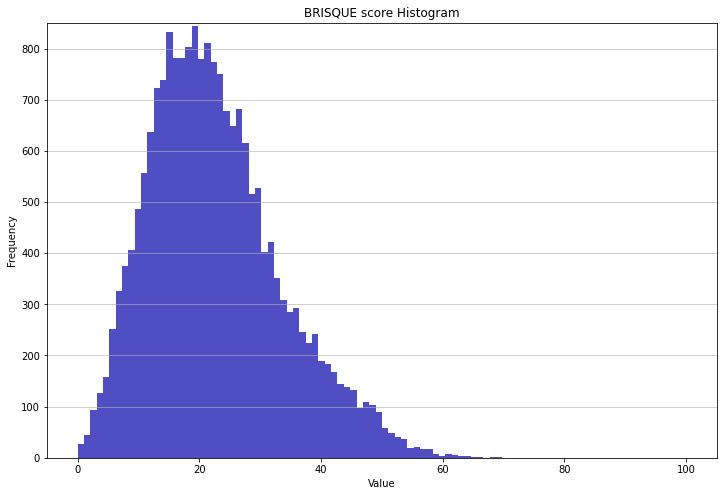

In [ ]:
# Histogram for BRISQUE with v2 preprocessed data
plt.figure(figsize=(12, 8))
n, bins, patches = plt.hist(x=v2_brisque_values, range=[0, 100], bins='auto', color='#0504aa',
                            alpha=0.7)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('BRISQUE score Histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

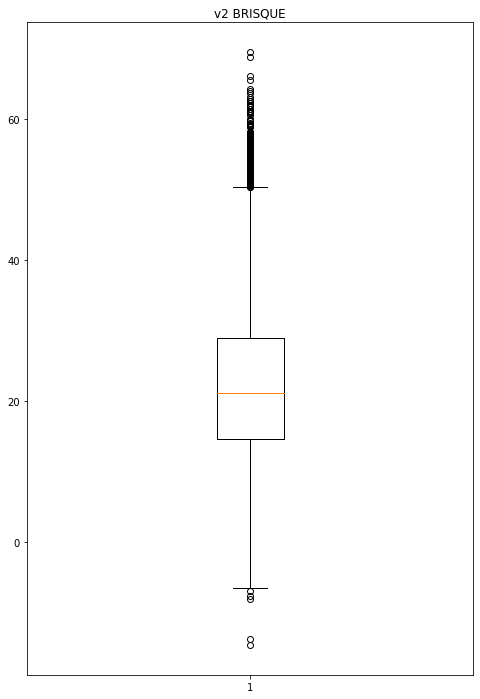

In [ ]:
# box plot for BRISQUE
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(1,1,1)
ax.boxplot(v2_brisque_values)
ax.set_title('v2 BRISQUE')
plt.show()

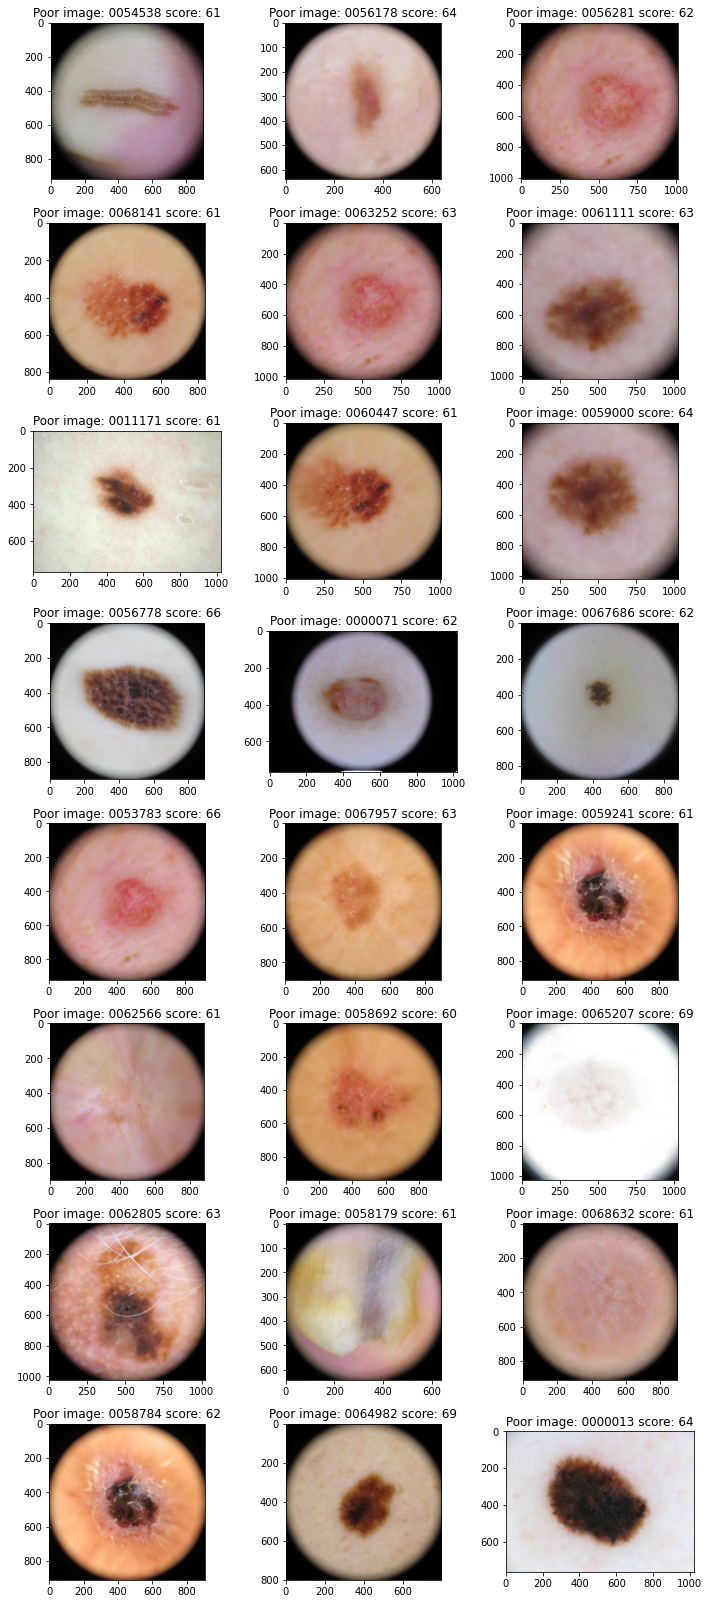

In [ ]:
# visulisation images with a high (and therefore poor) BRISQUE quality score of greater than 60 and lower than 20

# greater than 60
poor_brisq = {k: v for k, v in v2_prepro_brisque_metrics_reopened.items() if v >= 60}
#len(poor_brisq)
#28

#initialising subplot index
subplot_index = 1
no_images = len(poor_brisq)
# creating the figure
fig = plt.figure(figsize=(10,200))

# iterating over images
for i, (image_file, score) in enumerate(poor_brisq.items(), start=1):
    original_image = io.imread(image_file)
    # Plot input image
    ax = fig.add_subplot(no_images*3, 3, subplot_index)
    ax.imshow(original_image)
    ax.set_title(f"Poor image: {image_file[-11:-4]} score: {round(score)}")
    subplot_index += 1

plt.tight_layout()
plt.show()

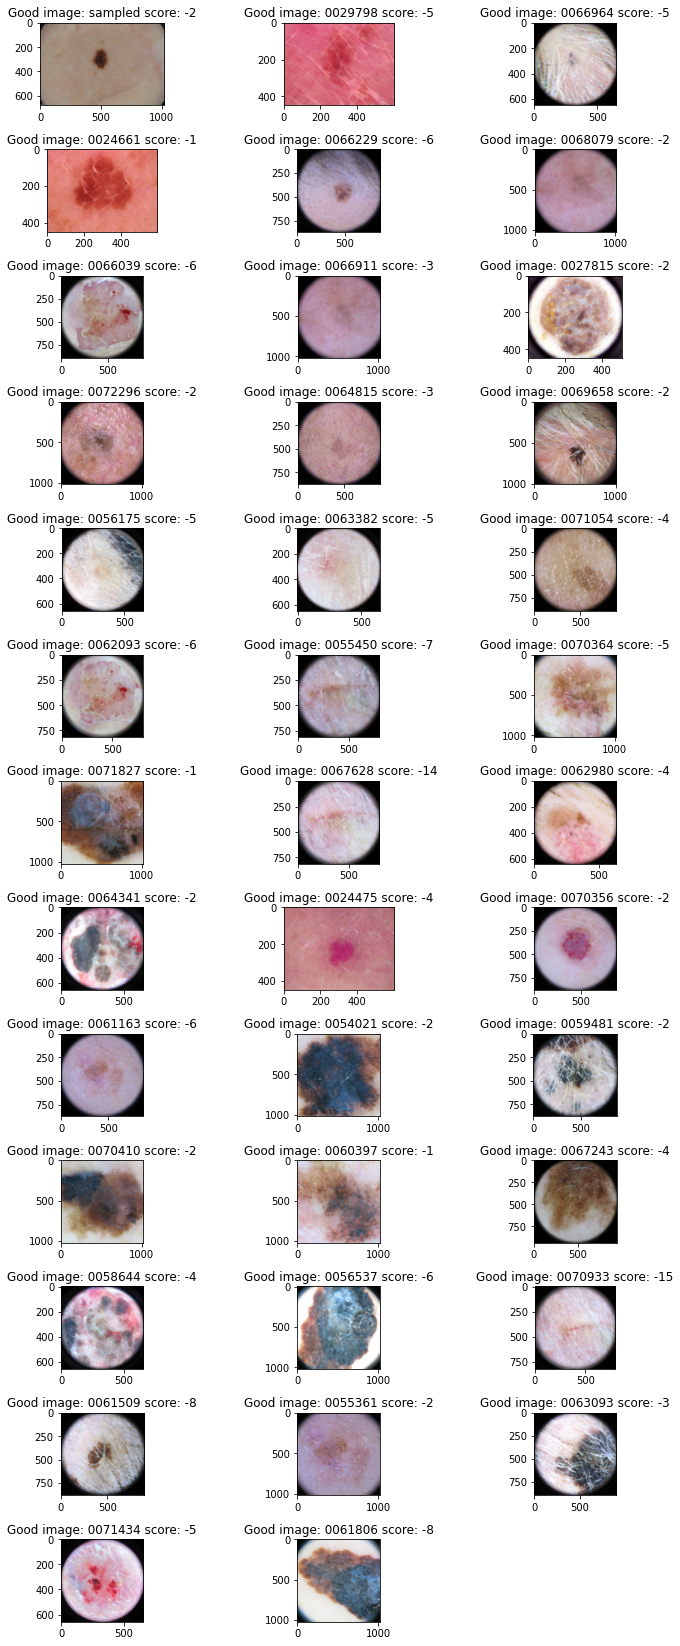

In [ ]:
## GOOD BRISQUE SCORE

# smaller than 5
good_brisq = {k: v for k, v in v2_prepro_brisque_metrics_reopened.items() if v <= -1}

#initialising subplot index
subplot_index = 1
no_images = len(good_brisq)
# creating the figure
fig = plt.figure(figsize=(10,200))

# iterating over images
for i, (image_file, score) in enumerate(good_brisq.items(), start=1):
    original_image = io.imread(image_file)
    # Plot input image
    ax = fig.add_subplot(no_images*3, 3, subplot_index)
    ax.imshow(original_image)
    ax.set_title(f"Good image: {image_file[-11:-4]} score: {round(score)}")
    subplot_index += 1

plt.tight_layout()
plt.show()

##BRISQUE for v2 TEST Preprocessed data (i.e. with hair removal and black circle crop applied)

In [9]:
root_path = "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/test"

test_brisque_metrics = v2_quality_assessment(brisque, root_path)

Running pool


  0%|          | 0/2534 [00:00<?, ?it/s]Downloading: "https://github.com/photosynthesis-team/piq/releases/download/v0.4.0/brisque_svm_weights.pt" to /root/.cache/torch/hub/checkpoints/brisque_svm_weights.pt
Downloading: "https://github.com/photosynthesis-team/piq/releases/download/v0.4.0/brisque_svm_weights.pt" to /root/.cache/torch/hub/checkpoints/brisque_svm_weights.pt


  0%|          | 0.00/112k [00:00<?, ?B/s]

  0%|          | 0.00/112k [00:00<?, ?B/s]

100%|██████████| 2534/2534 [05:56<00:00,  7.10it/s]


In [10]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/test_brisque_metrics.json", "w") as f:
    json.dump(test_brisque_metrics, f, indent=4)

In [11]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/test_brisque_metrics.json", "r") as f:
    test_brisque_metrics_reopened = json.load(f)

##BRISQUE for v2 VAL Preprocessed data (i.e. with hair removal and black circle crop applied)

In [14]:
root_path = "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_v2_prepro/val"

val_brisque_metrics = v2_quality_assessment(brisque, root_path)

Running pool


100%|██████████| 2533/2533 [04:08<00:00, 10.17it/s]


In [15]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/val_brisque_metrics.json", "w") as f:
    json.dump(val_brisque_metrics, f, indent=4)

In [16]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/val_brisque_metrics.json", "r") as f:
    val_brisque_metrics_reopened = json.load(f)

## Total Variation

In [ ]:
image_folder = "/content/drive/MyDrive/Dissertation/skin_lesion_data/ISIC_2019_Training_Input"
total_variation_metrics = quality_assessment(total_variation, image_folder)

Running pool


100%|██████████| 25331/25331 [20:04<00:00, 21.03it/s]


In [ ]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/total_variation_metrics.json", "w") as f:
    json.dump(total_variation_metrics, f, indent=4)

In [ ]:
with open("/content/drive/MyDrive/Dissertation/skin_lesion_data/total_variation_metrics.json", "r") as f:
    tv_metrics_reopened = json.load(f)

In [ ]:
total_variation_values = tv_metrics_reopened.values()
tv_mean = mean(total_variation_values)
print(tv_mean)

25.707741485233676


(0.0, 1270.0)

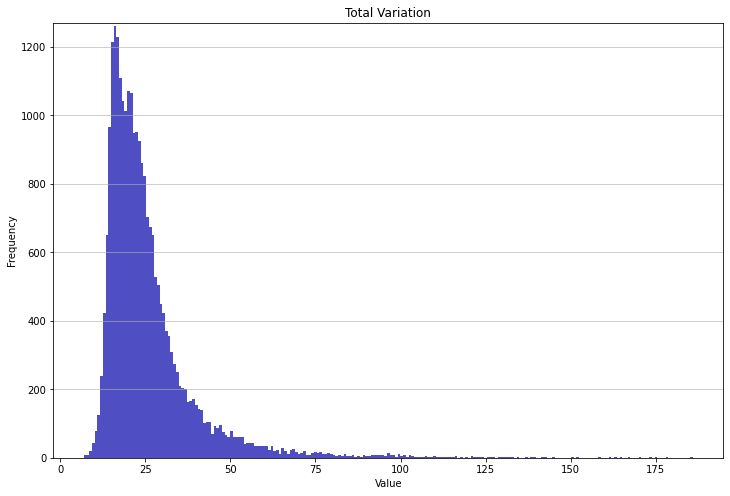

In [ ]:
# Histogram for TV
plt.figure(figsize=(12, 8))
n, bins, patches = plt.hist(x=total_variation_values, bins='auto', color='#0504aa',
                            alpha=0.7)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Total Variation')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

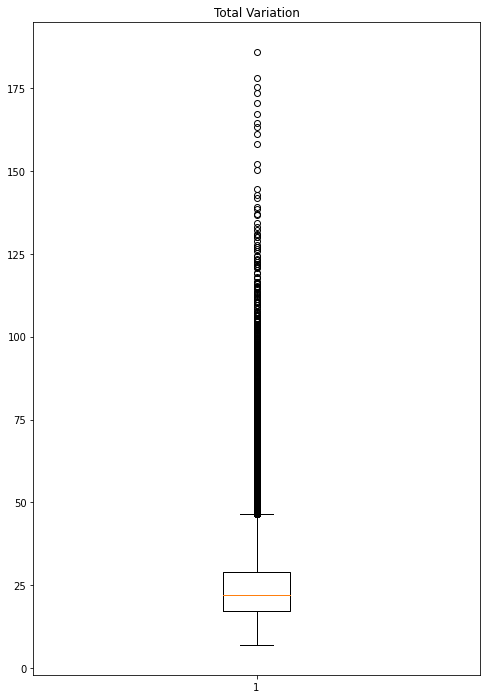

In [ ]:
# box plot for TV
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(1,1,1)
ax.boxplot(total_variation_values)
ax.set_title('Total Variation')
plt.show()

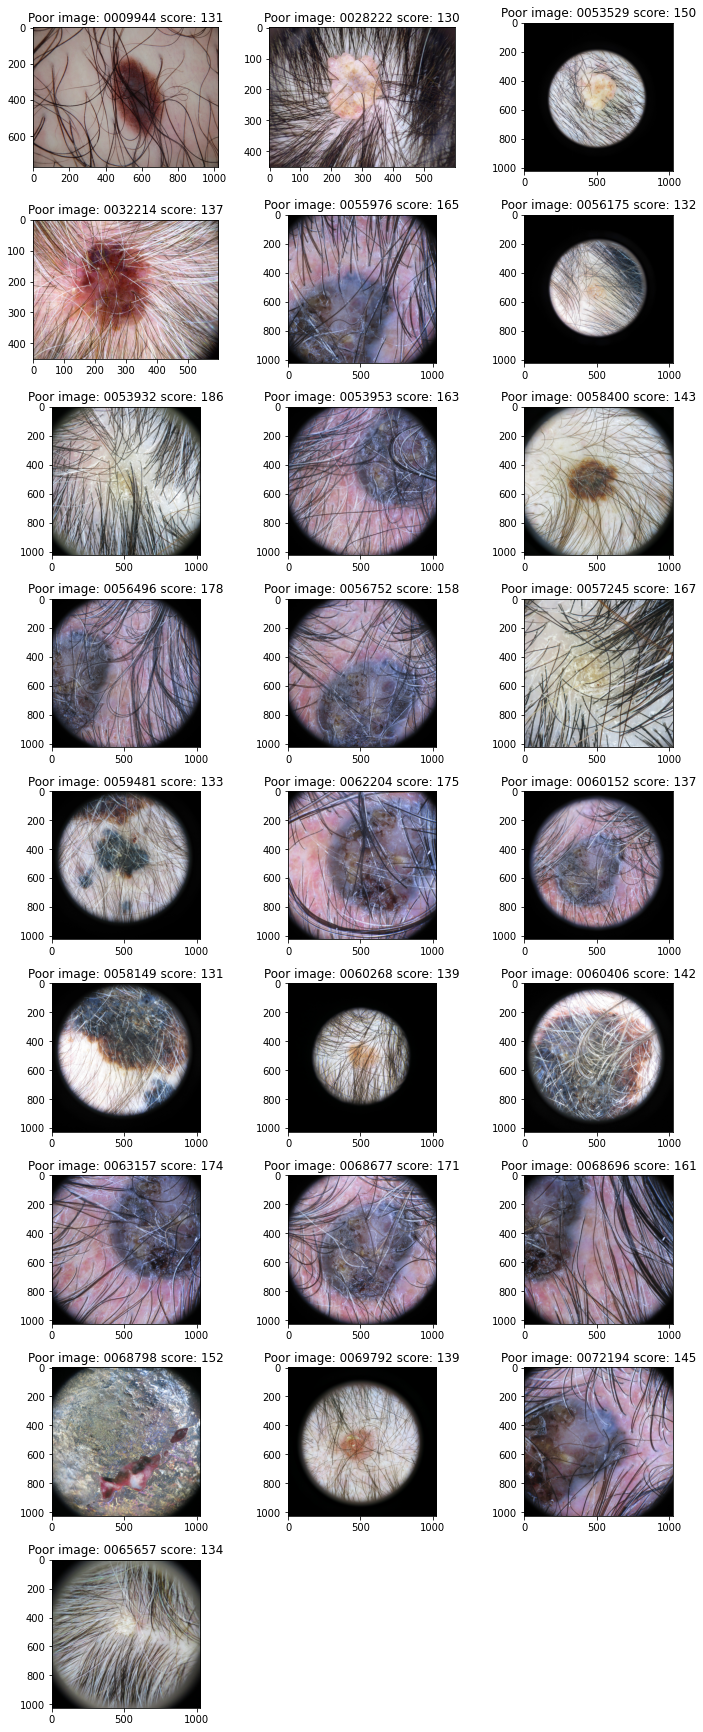

In [ ]:
# high variation (poor) images 

# greater than 150
poor_tv = {k: v for k, v in tv_metrics_reopened.items() if v >= 130}

#initialising subplot index
subplot_index = 1
no_images = len(poor_tv)
# creating the figure
fig = plt.figure(figsize=(10,200))

# iterating over images
for i, (image_file, score) in enumerate(poor_tv.items(), start=1):
    original_image = io.imread(image_file)
    # Plot input image
    ax = fig.add_subplot(no_images*3, 3, subplot_index)
    ax.imshow(original_image)
    ax.set_title(f"Poor image: {image_file[-11:-4]} score: {round(score)}")
    subplot_index += 1

plt.tight_layout()
plt.show()


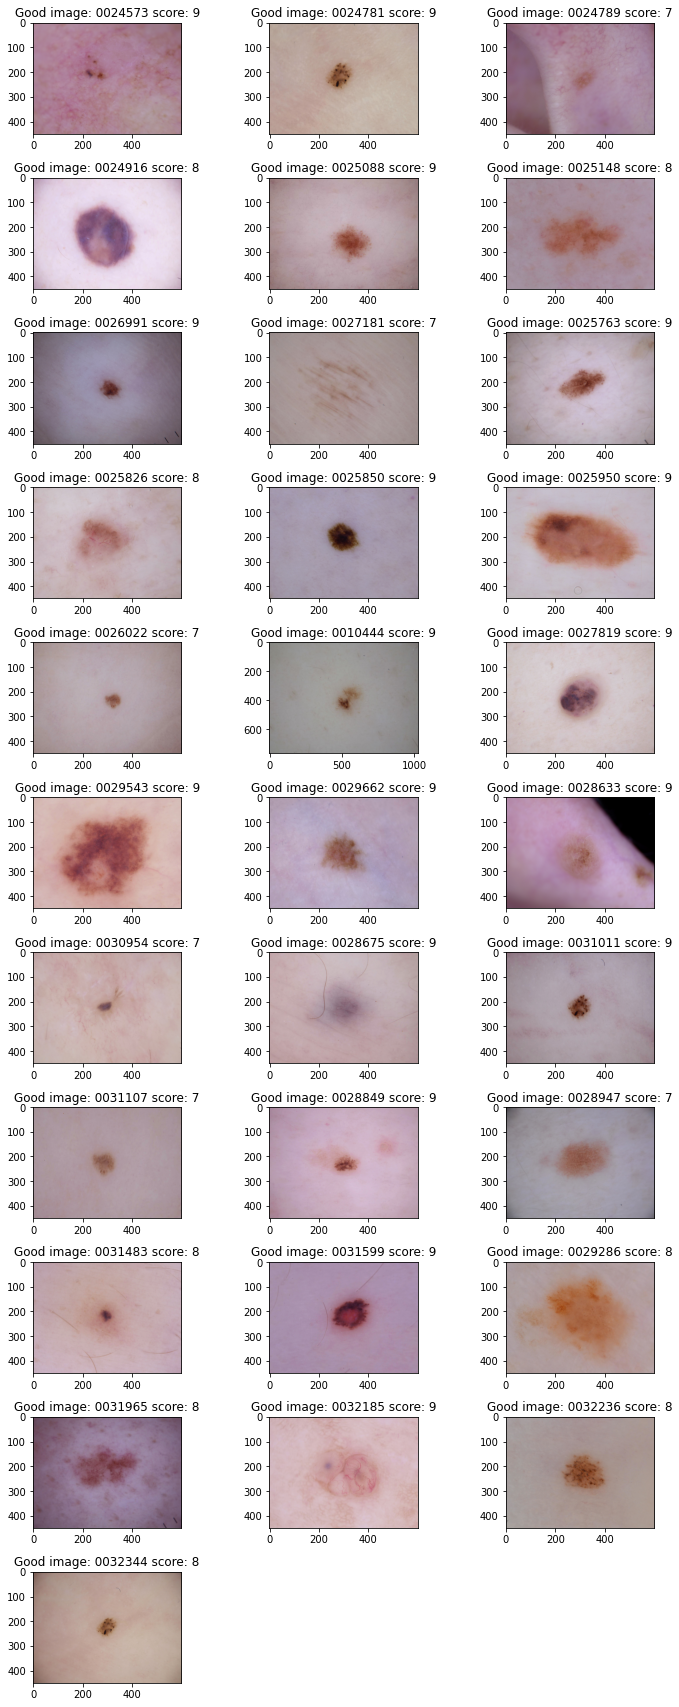

In [ ]:
# Low variation (good) images 

# less than 10
good_tv = {k: v for k, v in tv_metrics_reopened.items() if v <= 9}


#initialising subplot index
subplot_index = 1
no_images = len(good_tv)
# creating the figure
fig = plt.figure(figsize=(10,200))

# iterating over images
for i, (image_file, score) in enumerate(good_tv.items(), start=1):
    original_image = io.imread(image_file)
    # Plot input image
    ax = fig.add_subplot(no_images*3, 3, subplot_index)
    ax.imshow(original_image)
    ax.set_title(f"Good image: {image_file[-11:-4]} score: {round(score)}")
    subplot_index += 1

plt.tight_layout()
plt.show()